In [29]:
# import tarfile
# import json

# path = r"data\American Stories Raw\faro_1869.tar.gz"

# with tarfile.open(path, "r:gz") as tar:
#     for member in tar.getmembers():
#         if member.name.endswith(".json"):
#             f = tar.extractfile(member)
#             data = json.load(f)
#             print(json.dumps(data, indent=2))
#             break  # stop after first JSON file

In [31]:
import csv
import re
import os
import tarfile
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from glob import glob

# Try to use orjson (much faster), fall back to stdlib json
try:
    import orjson as json
    def load_json(f):
        return json.loads(f.read())
except ImportError:
    import json
    def load_json(f):
        return json.load(f)

# Optional: progress bar
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable, **kwargs):
        return iterable

data_folder = "data/American Stories Raw"

# Pre-compile regex patterns (avoid recompilation per call)
NAME_PATTERN = re.compile(r'^([^(\[]+)')
LOCATION_PATTERN = re.compile(r'\(([^)]+)\)')
BRACKET_PATTERN = re.compile(r'\[([^\]]+)\]')
BRACKET_REMOVE_PATTERN = re.compile(r'\s*\[[^\]]+\]')
YEAR_DIGITS_PATTERN = re.compile(r'\d{4}.*')
FILENAME_YEAR_PATTERN = re.compile(r'(\d{4})')

# State abbreviation mapping (unchanged)
STATE_ABBREV = {
    'al': 'Alabama', 'ak': 'Alaska', 'az': 'Arizona', 'ar': 'Arkansas',
    'ca': 'California', 'co': 'Colorado', 'ct': 'Connecticut', 'de': 'Delaware',
    'fl': 'Florida', 'ga': 'Georgia', 'hi': 'Hawaii', 'id': 'Idaho',
    'il': 'Illinois', 'in': 'Indiana', 'ia': 'Iowa', 'ks': 'Kansas', 'kan': 'Kansas',
    'ky': 'Kentucky', 'la': 'Louisiana', 'me': 'Maine', 'md': 'Maryland',
    'ma': 'Massachusetts', 'mi': 'Michigan', 'mn': 'Minnesota', 'ms': 'Mississippi',
    'mo': 'Missouri', 'mt': 'Montana', 'ne': 'Nebraska', 'nv': 'Nevada',
    'nh': 'New Hampshire', 'nj': 'New Jersey', 'nm': 'New Mexico', 'ny': 'New York',
    'nc': 'North Carolina', 'nd': 'North Dakota', 'oh': 'Ohio', 'ohio': 'Ohio',
    'ok': 'Oklahoma', 'or': 'Oregon', 'pa': 'Pennsylvania', 'ri': 'Rhode Island',
    'sc': 'South Carolina', 's.c': 'South Carolina',
    'sd': 'South Dakota', 's.d': 'South Dakota',
    'tn': 'Tennessee', 'tx': 'Texas', 'ut': 'Utah',
    'vt': 'Vermont', 'va': 'Virginia', 'wa': 'Washington', 'wv': 'West Virginia',
    'wi': 'Wisconsin', 'wis': 'Wisconsin', 'wy': 'Wyoming',
    'd.c': 'District of Columbia'
}

def extract_info(entry):
    """Extract newspaper name, town, and state from a title string."""
    name_match = NAME_PATTERN.match(entry)
    name = name_match.group(1).strip().rstrip('.') if name_match else entry
    
    location_match = LOCATION_PATTERN.search(entry)
    town, state = '', ''
    
    if location_match:
        location = location_match.group(1)
        bracket_match = BRACKET_PATTERN.search(location)
        state_abbr = None
        
        if bracket_match:
            state_abbr = bracket_match.group(1).lower().rstrip('.')
            location = BRACKET_REMOVE_PATTERN.sub('', location)
        
        loc_parts = [p.strip() for p in location.split(',')]
        
        if state_abbr:
            town = loc_parts[0] if loc_parts else ''
            state = STATE_ABBREV.get(state_abbr, state_abbr.upper())
        elif len(loc_parts) >= 2:
            town = loc_parts[0]
            state_part = loc_parts[-1].lower().rstrip('.').strip()
            state_part = YEAR_DIGITS_PATTERN.sub('', state_part).strip()
            state = STATE_ABBREV.get(state_part, state_part.upper())
    
    return {'name': name, 'town': town, 'state': state}

def process_tar_file(file_path):
    """Process a single tar file and return (year, {title: (count, issn, lccn)})."""
    match = FILENAME_YEAR_PATTERN.search(os.path.basename(file_path))
    year = match.group(1) if match else None
    
    if not year:
        return None, {}
    
    # Store {title: [count, issn, lccn]}
    data = {}
    
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar:
            if not member.isfile() or not member.name.endswith(".json"):
                continue
            
            f = tar.extractfile(member)
            if not f:
                continue
                
            try:
                content = load_json(f)
                lccn_obj = content.get('lccn', {})
                title = lccn_obj.get("title", "")
                if title:
                    title_lower = title.lower()
                    if title_lower in data:
                        data[title_lower][0] += 1
                    else:
                        issn = lccn_obj.get("issn", "")
                        lccn = lccn_obj.get("lccn", "")
                        data[title_lower] = [1, issn, lccn]
            except Exception:
                continue
    
    return year, data

def main():
    tar_files = sorted(glob(os.path.join(data_folder, "*.tar.gz")))
    print(f"Found {len(tar_files)} tar files to process")
    
    if not tar_files:
        print("No tar files found!")
        return
    
    # Process files in parallel
    # Store {title: {'years': {year: count}, 'issn': str, 'lccn': str}}
    all_data = defaultdict(lambda: {'years': Counter(), 'issn': '', 'lccn': ''})
    years = set()
    
    # Use number of threads (I/O bound, so can use more than CPU count)
    max_workers = min(16, len(tar_files))
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_tar_file, f): f for f in tar_files}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing tar files"):
            year, data = future.result()
            if year:
                years.add(year)
                for title, (count, issn, lccn) in data.items():
                    all_data[title]['years'][year] += count
                    # Store issn/lccn if we don't have them yet (they're the same across years)
                    if issn and not all_data[title]['issn']:
                        all_data[title]['issn'] = issn
                    if lccn and not all_data[title]['lccn']:
                        all_data[title]['lccn'] = lccn
    
    years = sorted(years)
    print(f"\nYears found: {years}")
    
    # Build final results
    results = []
    for title, title_data in all_data.items():
        info = extract_info(title)
        info['issn'] = title_data['issn']
        info['lccn'] = title_data['lccn']
        total = 0
        year_counts = title_data['years']
        for year in years:
            c = year_counts.get(year, 0)
            info[f'{year}_count'] = c
            total += c
        info['total'] = total
        results.append(info)
    
    # Sort by total count descending
    results.sort(key=lambda x: x['total'], reverse=True)
    
    # Write to CSV
    fieldnames = ['name', 'town', 'state', 'issn', 'lccn'] + [f'{y}_count' for y in years] + ['total']
    
    with open('newspapers_all_years.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"\nCSV file created with {len(results)} unique newspapers.")
    
    # Preview top 5
    print("\nTop 5 newspapers by total count:")
    for r in results[:5]:
        year_counts_str = ", ".join(f"{y}: {r[f'{y}_count']}" for y in years if r[f'{y}_count'] > 0)
        print(f"  {r['name']} ({r['town']}, {r['state']}) - Total: {r['total']}")
        print(f"    {year_counts_str}")

if __name__ == "__main__":
    main()

Found 22 tar files to process


Processing tar files: 100%|██████████| 22/22 [36:21<00:00, 99.15s/it]   


Years found: ['1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890']

CSV file created with 1493 unique newspapers.

Top 5 newspapers by total count:
  new-york tribune (new york, N.Y) - Total: 49609
    1869: 1876, 1870: 1391, 1871: 1547, 1872: 1394, 1873: 1631, 1874: 1462, 1875: 2329, 1876: 1323, 1877: 1829, 1878: 1551, 1879: 1373, 1880: 2424, 1881: 2733, 1882: 2727, 1883: 2843, 1884: 2434, 1885: 2149, 1886: 1935, 1887: 3288, 1888: 3453, 1889: 3920, 1890: 3997
  evening star (washington, District of Columbia) - Total: 32979
    1869: 850, 1870: 1098, 1871: 1324, 1872: 1454, 1873: 1317, 1874: 1276, 1875: 1270, 1876: 1166, 1877: 517, 1878: 1292, 1879: 1349, 1880: 1413, 1881: 1602, 1882: 1663, 1883: 1569, 1884: 1452, 1885: 1570, 1886: 1397, 1887: 1816, 1888: 1915, 1889: 2741, 1890: 2928
  alexandria gazette (alexandria, District of Columbia) - Total: 25698
    1869: 

In [9]:
import pandas as pd

df = pd.read_csv('newspapers_all_years.csv')
count_cols = [c for c in df.columns if c.endswith('_count')]
agg = {c: 'sum' for c in count_cols}
agg.update({c: 'first' for c in ['name', 'town', 'state', 'lccn', 'total']})
result = df.groupby('issn', as_index=False).agg(agg)
result = result[df.columns].sort_values('total', ascending=False)
result.to_csv('newspapers_all_years.csv', index=False)

In [ ]:
# save all headlines

import pandas as pd

df = pd.read_csv('newspapers_all_years.csv')

# Get year columns (those ending in _count but not 'total')
year_cols = [c for c in df.columns if c.endswith('_count')]

# Count how many years have at least 10 scans for each newspaper
df['years_with_10plus'] = (df[year_cols] >= 10).sum(axis=1)

# Filter to newspapers with at least 3 such years
qualified = df[df['years_with_10plus'] >= 3].copy()

# Make a list of their names
newspaper_list = qualified['name'].tolist()

print(f"Found {len(newspaper_list)} newspapers with ≥10 scans in ≥3 years\n")
print("First 20:")
for name in newspaper_list[:20]:
    print(f"  • {name}")

import json
import tarfile
import csv
import re
from tqdm import tqdm
from glob import glob

data_folder = "data/American Stories Raw"
newspaper_set = set(n.lower() for n in newspaper_list)

def extract_name(title):
    """Extract newspaper name from title string."""
    match = re.match(r'^([^(\[]+)', title)
    return match.group(1).strip().rstrip('.').lower() if match else title.lower()

def clean(text):
    return ' '.join(text.split())

for tar_path in sorted(glob(f"{data_folder}/*.tar.gz")):
    year = tar_path.split("_")[-1].replace(".tar.gz", "")
    papers = {}  # {name: [headlines]}
    
    with tarfile.open(tar_path, "r:gz") as tar:
        for member in tqdm(tar.getmembers(), desc=year):
            if not member.name.endswith(".json"):
                continue
            f = tar.extractfile(member)
            if f:
                try:
                    data = json.load(f)
                    name = extract_name(data["lccn"]["title"])
                    if name not in newspaper_set:
                        continue
                    for bbox in data.get("bboxes", []):
                        if bbox.get("class") == "headline" and bbox.get("legibility") == "Legible":
                            papers.setdefault(name, []).append(clean(bbox["raw_text"]))
                except:
                    continue
    
    with open(f"headlines_{year}.json", "w", encoding="utf-8") as f:
        json.dump(papers, f)
    
    total = sum(len(h) for h in papers.values())
    print(f"Saved headlines_{year}.json: {len(papers)} papers, {total} headlines")

In [ ]:
# create topic_counts

import json
import re
from pathlib import Path
from collections import Counter

TOPIC_DICTIONARY = {
    "politics_elections": ["vote", "voter", "election", "ballot", "candidate", "party", "democrat", "republican", "campaign", "convention", "nominate", "poll", "ticket", "caucus", "primary"],
    "congress_government": ["congress", "senate", "house", "bill", "law", "passed", "veto", "president", "cabinet", "session", "committee", "amendment", "act", "senator", "representative"],
    "courts_law": ["court", "judge", "trial", "jury", "lawyer", "case", "verdict", "guilty", "sentence", "appeal", "supreme", "justice", "plaintiff", "defendant", "lawsuit"],
    "labor_workers": ["labor", "wage", "strike", "worker", "union", "factory", "employ", "hours", "boss", "mill", "mine", "miner", "coal", "iron", "shop"],
    "business_commerce": ["trade", "market", "price", "sell", "buy", "stock", "firm", "company", "merchant", "goods", "store", "profit", "business", "commercial", "dealer"],
    "finance_money": ["bank", "money", "gold", "silver", "coin", "dollar", "debt", "bond", "loan", "credit", "currency", "treasury", "mint", "panic", "deposit"],
    "railroads_transportation": ["railroad", "rail", "train", "depot", "freight", "passenger", "track", "line", "station", "route", "fare", "car", "engine", "express", "trunk"],
    "agriculture_farming": ["farm", "farmer", "crop", "wheat", "corn", "cattle", "harvest", "land", "acre", "grain", "wool", "cotton", "hog", "market", "price"],
    "immigration_foreign": ["immigrant", "foreign", "chinese", "irish", "german", "alien", "native", "citizen", "naturalize", "emigrant", "passport", "steamer", "arrival"],
    "crime_police": ["murder", "arrest", "police", "thief", "robbery", "prison", "criminal", "crime", "officer", "stolen", "gang", "mob", "riot", "lynch", "jail"],
    # Baseline common English words - high frequency words that should appear in readable text
    "_baseline_english": [
        # Articles and determiners
        "the", "a", "an", "this", "that", "these", "those",
        # Conjunctions and prepositions
        "and", "or", "but", "for", "with", "from", "by", "at", "on", "in", "to", "of",
        # Pronouns
        "he", "she", "it", "they", "we", "his", "her", "their", "who", "what",
        # Common verbs
        "is", "are", "was", "were", "be", "been", "have", "has", "had", "will", "would",
        "said", "says", "made", "came", "went", "took", "gave", "found", "left",
        # Common nouns likely in headlines
        "man", "men", "woman", "city", "state", "country", "day", "year", "time",
        "new", "old", "great", "last", "first", "two", "three", "one", "all", "more",
        # News-specific common words
        "today", "yesterday", "here", "there", "now", "after", "before", "over", "about"
    ],
}

# Precompile: map each term to its topic(s) for O(1) lookup
TERM_TO_TOPICS = {}
for topic, terms in TOPIC_DICTIONARY.items():
    for term in terms:
        TERM_TO_TOPICS.setdefault(term, []).append(topic)

def tokenize(text):
    return re.findall(r'[a-z]+', text.lower())

def count_topics_in_headlines(headlines):
    counts = Counter()
    total = 0
    for headline in headlines:
        for token in tokenize(headline):
            total += 1
            for topic in TERM_TO_TOPICS.get(token, []):
                counts[topic] += 1
    return dict(counts), total

def calculate_ocr_grade(baseline_hits, total_tokens):
    """
    Calculate OCR quality grade based on baseline English word detection.
    
    Expected rate: ~40-60% of tokens in readable English text should be 
    common words (articles, prepositions, etc.)
    
    Returns a score 0-1 where 1 = excellent OCR quality
    """
    if total_tokens == 0:
        return 0.0
    
    baseline_rate = baseline_hits / total_tokens
    
    # Normalize: expect ~40% baseline words in good OCR
    # Cap at 1.0 (rates above 40% all count as excellent)
    EXPECTED_BASELINE_RATE = 0.30
    grade = min(1.0, baseline_rate / EXPECTED_BASELINE_RATE)
    
    return round(grade, 3)

def process_year(filepath):
    with open(filepath) as f:
        data = json.load(f)
    
    results = {}
    for paper, headlines in data.items():
        topic_counts, total_tokens = count_topics_in_headlines(headlines)
        
        # Extract baseline count and calculate grade
        baseline_hits = topic_counts.pop("_baseline_english", 0)
        ocr_grade = calculate_ocr_grade(baseline_hits, total_tokens)
        
        results[paper] = {
            "topic_counts": topic_counts,
            "total_headlines": len(headlines),
            "total_tokens": total_tokens,
            "baseline_hits": baseline_hits,
            "ocr_grade": ocr_grade,
            # Normalized counts: topic hits per 1000 tokens, adjusted for OCR quality
            "normalized_counts": {
                topic: round((count / total_tokens) * 1000 / max(ocr_grade, 0.1), 2)
                for topic, count in topic_counts.items()
            } if total_tokens > 0 and topic_counts else {}
        }
    return results

def main(data_dir="data/headlines"):
    files = sorted(Path(data_dir).glob("headlines_*.json"))
    all_results = {}
    
    for f in files:
        year = re.search(r'headlines_(\d{4})\.json', f.name).group(1)
        print(f"Processing {year}...")
        all_results[year] = process_year(f)
    
    # Print OCR quality summary
    print("\n=== OCR Quality Summary ===")
    for year in sorted(all_results.keys()):
        print(f"\n{year}:")
        for paper, stats in sorted(all_results[year].items(), key=lambda x: x[1]["ocr_grade"], reverse=True):
            grade_pct = stats["ocr_grade"] * 100
            print(f"  {paper}: {grade_pct:.1f}% readable ({stats['baseline_hits']}/{stats['total_tokens']} baseline words)")
    
    with open("topic_counts.json", "w") as out:
        json.dump(all_results, out, indent=2)
    
    print(f"\nDone. Processed {len(files)} years -> topic_counts.json")

if __name__ == "__main__":
    main()

Processing 1869...
Processing 1870...
Processing 1871...
Processing 1872...
Processing 1873...
Processing 1874...
Processing 1875...
Processing 1876...
Processing 1877...
Processing 1878...
Processing 1879...
Processing 1880...
Processing 1881...
Processing 1882...
Processing 1883...
Processing 1884...
Processing 1885...
Processing 1886...
Processing 1887...
Processing 1888...
Processing 1889...
Processing 1890...

=== OCR Quality Summary ===

1869:
  saint mary's beacon: 100.0% readable (4/11 baseline words)
  yorkville enquirer: 93.2% readable (4645/16618 baseline words)
  herald and tribune: 85.6% readable (311/1211 baseline words)
  the central presbyterian: 84.9% readable (4052/15900 baseline words)
  wyandot county republican: 82.9% readable (4899/19692 baseline words)
  the evening telegraph: 82.8% readable (47217/190115 baseline words)
  the richmond palladium: 82.4% readable (3204/12955 baseline words)
  wilmington journal: 82.3% readable (5031/20377 baseline words)
  urbana u

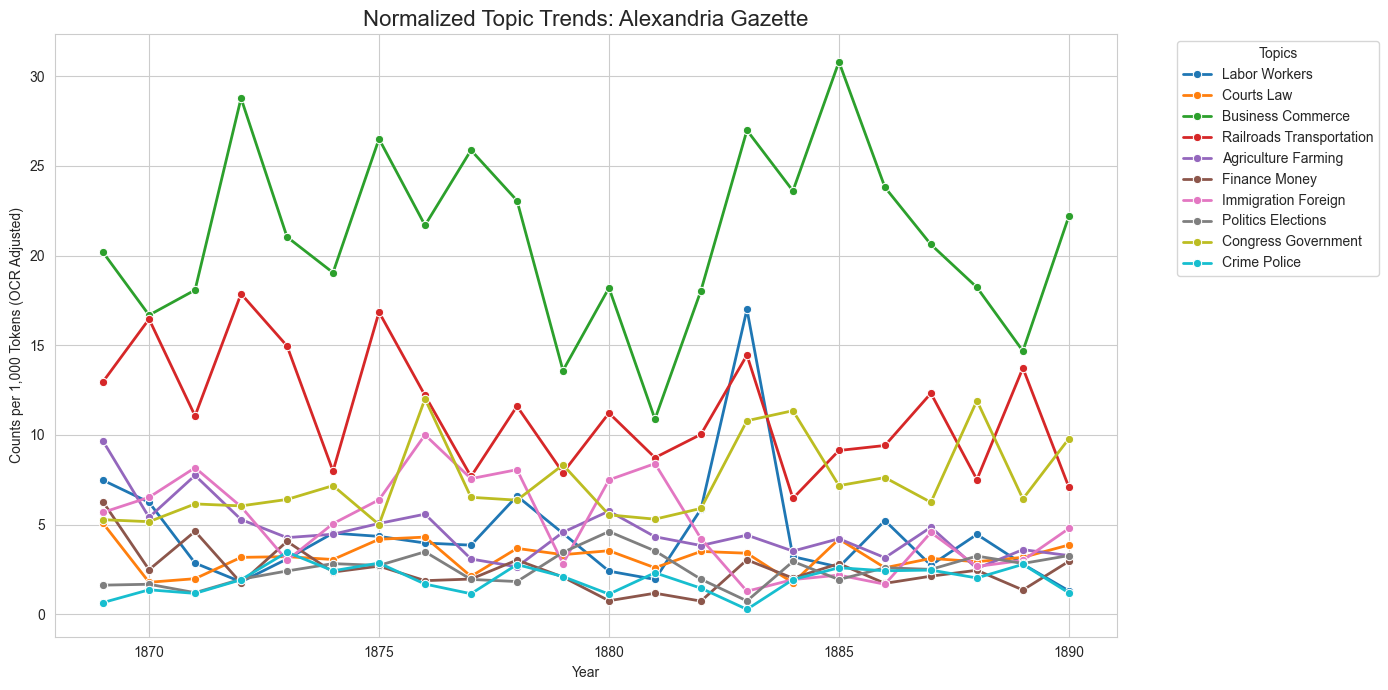

In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (assuming it's in a file named 'data.json')
with open('topic_counts.json', 'r') as f:
    data = json.load(f)

def plot_normalized_trends(json_data, target_paper="alexandria gazette"):
    rows = []
    
    # Iterate through each year in the JSON
    for year, papers in json_data.items():
        # Check if the specific newspaper exists for that year
        if target_paper in papers:
            paper_entry = papers[target_paper]
            
            # Access the 'normalized_counts' dictionary
            if "normalized_counts" in paper_entry:
                norm_counts = paper_entry["normalized_counts"]
                
                for topic, value in norm_counts.items():
                    rows.append({
                        "Year": int(year),
                        "Topic": topic.replace("_", " ").title(),
                        "Normalized Count": value
                    })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    if df.empty:
        print(f"No data found for {target_paper}")
        return

    # Plotting
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    # Create the line plot
    plot = sns.lineplot(
        data=df, 
        x="Year", 
        y="Normalized Count", 
        hue="Topic", 
        marker="o",
        linewidth=2
    )
    
    # Formatting
    plt.title(f"Normalized Topic Trends: {target_paper.title()}", fontsize=16)
    plt.ylabel("Counts per 1,000 Tokens (OCR Adjusted)")
    plt.xlabel("Year")
    
    # Move legend outside the plot area
    plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_normalized_trends(data)

In [1]:
import pandas as pd

df = pd.read_csv('newspapers_all_years_updated.csv')
year_cols = [c for c in df.columns if c.endswith('_count') and c != 'total']
df = df[(df[year_cols] >= 10).sum(axis=1) >= 3]
df.to_csv('newspapers_all_years_updated.csv', index=False)

In [19]:
# match our newspapers from Melissa Dell onto Rowell's

import csv
import html
import re
import unicodedata
from thefuzz import fuzz, process

# Configuration
FUZZY_THRESHOLD = 80  # Adjust this threshold as needed (0-100)

# Special case mappings for known location mismatches
# Format: (town, state_first_letter) in newspapers_all_years -> (town, state_first_letter) in master
LOCATION_OVERRIDES = {
    ('alexandria', 'd'): ('alexandria', 'v'),  # Alexandria Gazette: DC -> Virginia
}

def load_csv(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return list(reader)

def normalize(text):
    """Normalize text for comparison."""
    if text is None:
        return ""
    return text.strip().lower()

def strip_court_house(text):
    """Remove 'c.h.' (court house) suffix from a normalized string."""
    return re.sub(r'\s*c\.?\s*h\.?\s*$', '', text).strip()

def normalize_unicode(text):
    """Decode HTML entities and remove diacritics."""
    if text is None:
        return ""
    # Decode HTML entities like &amp; -> & and &#39; -> '
    text = html.unescape(text)
    # Manual fix for known encoding issue
    text = text.replace('phå"nix', 'phenix')
    # Normalize to NFD, then remove combining characters (accents/diacritics)
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

def remove_the(text):
    """Remove 'the' from beginning of newspaper name."""
    if text is None:
        return ""
    text = text.strip()
    if text.lower().startswith('the '):
        return text[4:]
    return text

def remove_town_from_name(name, town):
    """Remove town name from newspaper name, handling special characters."""
    if not name or not town:
        return name
    # Create pattern that matches town with optional special chars between words
    # e.g., "new york" matches "new-york", "new york", "new_york", etc.
    town_words = town.lower().split()
    pattern = r'[\s\-_]*'.join(re.escape(word) for word in town_words)
    # Remove town from name (case insensitive), including trailing space/special chars
    result = re.sub(pattern + r'[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def remove_daily(name):
    """Remove 'daily' from newspaper name."""
    if not name:
        return name
    result = re.sub(r'\b(daily|weekly)\b[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def has_sufficient_yearly_counts(row, min_count=10, min_years=3):
    """Check if newspaper has at least min_count in at least min_years separate years."""
    years_meeting_threshold = 0
    for key, value in row.items():
        if key.endswith('_count'):
            try:
                count = int(value) if value else 0
                if count >= min_count:
                    years_meeting_threshold += 1
            except ValueError:
                continue
    return years_meeting_threshold >= min_years

def get_state_first_letter(state):
    """Get first letter of state, normalized."""
    if state is None or len(state.strip()) == 0:
        return ""
    return state.strip()[0].lower()

def get_lookup_keys(town, state_letter):
    """Get all lookup keys to try, including any overrides."""
    keys = [(town, state_letter)]
    original_key = (town, state_letter)
    if original_key in LOCATION_OVERRIDES:
        keys.append(LOCATION_OVERRIDES[original_key])
    return keys

def main():
    # Load both CSVs
    master = load_csv('data/master.csv')
    newspapers = load_csv('data/newspapers_all_years_updated.csv')
    
    matches = []
    unmatched_diagnostics = []
    
    # Build a lookup from master by (town, state_first_letter)
    master_by_location = {}
    for idx, row in enumerate(master):
        town = normalize(row.get('town', ''))
        state_letter = get_state_first_letter(row.get('state', ''))
        key = (town, state_letter)
        if key not in master_by_location:
            master_by_location[key] = []
        master_by_location[key].append({
            'name': normalize_unicode(row.get('newspaper_name', '')),
            'idx': idx
        })
    
    # Process each row in newspapers_all_years
    for news_row in newspapers:
        # Skip if doesn't meet yearly count threshold
        if not has_sufficient_yearly_counts(news_row):
            continue
        
        news_town = strip_court_house(normalize(news_row.get('town', '')))
        news_state_letter = get_state_first_letter(news_row.get('state', ''))
        news_name = news_row.get('name', '')
        news_issn = news_row.get('issn', '')
        # Normalize unicode before further processing
        news_name_normalized = normalize_unicode(news_name)
        # Remove "the" and town name for matching
        news_name_for_matching = remove_town_from_name(remove_the(news_name_normalized), news_row.get('town', ''))
        
        # Get all keys to try (original + any overrides)
        keys_to_try = get_lookup_keys(news_town, news_state_letter)
        
        # Check if there are newspapers in master with same town and state first letter
        matched = False
        for key in keys_to_try:
            if matched:
                break
                
            if key in master_by_location:
                candidates = master_by_location[key]
                
                if candidates:
                    candidate_names = [c['name'] for c in candidates]
                    
                    # First pass: match with "the" and town removed
                    best_match, score = process.extractOne(
                        news_name_for_matching, 
                        candidate_names, 
                        scorer=fuzz.token_sort_ratio
                    )
                    
                    if score >= FUZZY_THRESHOLD:
                        master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                        matches.append({
                            'newspapers_all_years_name': news_name,
                            'issn': news_issn,
                            'master_name': best_match,
                            'master_id': master_idx
                        })
                        matched = True
                    else:
                        # Second pass: also remove "daily"
                        news_name_no_daily = remove_daily(news_name_for_matching)
                        
                        if news_name_no_daily and news_name_no_daily != news_name_for_matching:
                            best_match, score = process.extractOne(
                                news_name_no_daily, 
                                candidate_names, 
                                scorer=fuzz.token_sort_ratio
                            )
                            
                            if score >= FUZZY_THRESHOLD:
                                master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                                matches.append({
                                    'newspapers_all_years_name': news_name,
                                    'issn': news_issn,
                                    'master_name': best_match,
                                    'master_id': master_idx
                                })
                                matched = True
        
        # If no match found, still add the row with empty master_name
        if not matched:
            matches.append({
                'newspapers_all_years_name': news_name,
                'issn': news_issn,
                'master_name': '',
                'master_id': ''
            })
            
            # Collect diagnostic info for unmatched papers
            keys_to_try = get_lookup_keys(news_town, news_state_letter)
            all_candidates = []
            town_found = False
            for key in keys_to_try:
                if key in master_by_location:
                    town_found = True
                    all_candidates.extend(master_by_location[key])
            
            unmatched_diagnostics.append({
                'name': news_name,
                'town': news_row.get('town', ''),
                'state': news_row.get('state', ''),
                'issn': news_issn,
                'lccn': news_row.get('lccn', ''),
                'town_found': town_found,
                'candidates': all_candidates
            })
    
    # Write output
    with open('matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(matches)
    
    # Write unmatched diagnostics as text file
    with open('unmatched_diagnostics.txt', 'w', encoding='utf-8') as f:
        f.write("UNMATCHED NEWSPAPERS DIAGNOSTICS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total unmatched: {len(unmatched_diagnostics)}\n\n")
        
        for i, diag in enumerate(unmatched_diagnostics, 1):
            f.write(f"--- Entry {i} ---\n")
            f.write(f"Name:  {diag['name']}\n")
            f.write(f"Town:  {diag['town']}\n")
            f.write(f"State: {diag['state']}\n")
            f.write(f"ISSN:  {diag['issn']}\n")
            f.write(f"LCCN:  {diag['lccn']}\n")
            f.write(f"Town found in master: {'Yes' if diag['town_found'] else 'No'}\n")
            if diag['candidates']:
                f.write("Master candidates in town:\n")
                for candidate in diag['candidates']:
                    f.write(f"  - {candidate['name']} (master_id: {candidate['idx']})\n")
            else:
                f.write("Master candidates in town: (none)\n")
            f.write("\n")
    
    matched_count = sum(1 for m in matches if m['master_name'])
    unmatched_count = len(matches) - matched_count
    print(f"Found {matched_count} matches and {unmatched_count} unmatched. Output written to matches.csv")
    print(f"Unmatched diagnostics written to unmatched_diagnostics.txt")

if __name__ == '__main__':
    main()

Found 387 matches and 219 unmatched. Output written to matches.csv
Unmatched diagnostics written to unmatched_diagnostics.txt


In [33]:
import csv

# Manual matches identified from diagnostic review
# Format: (newspapers_all_years_name, master_name, master_id)
MANUAL_MATCHES = [
    ("idaho semi-weekly world", "Idaho Worlds", 12622),
    ("carson daily appeal", "APPEAL", 30291),
    ("the aegis &amp", "Zgis and Intelligencer", 22316),
    ("vermont phå\u201cnix", "Vermont Phenix", 45226),
    ("the jackson standard", "Standard", 38082),
    ("the evening argus", "Argus", 15329),
    ("hermanner volksblatt", "Hermanner Volksblatt", 27735),
    ("wheeling sunday register", "Register", 46685),
    ("the new bloomfield, pa. times", "Times", 40864),
    ("the bloomfield times", "Times", 40864),
    ("maryland independent", "INDEPENDENT", 22504),
    ("the daily morning astorian", "MORNING ASTORIAN", 39254),
    ("the press", "Tolland County Press", 10778),
    ("the daily astorian", "Astorian", 39263),
    ("the manning times", "KK. TIMES", 42959),
    ("louisiana capitolian", "CAPITOLIAN ADVOCATE", 21548),
    ("national opinion", "Opinion", 45221),
    ("idaho county free press", "CO. FREE PRESS", 12615),
    ("the columbia herald", "Herald and Mail", 43323),
    ("wyandot county republican", "Wyandot Co. Repub-lican", 38985),
    ("the wilmingtonian", "WILMINGTONIAN", 11494),
    ("the lincoln county herald", "Herald", 29079),
    ("juniata sentinel", "Juniata Sentineland Re-publican", 40777),
    ("the star of pascagoula", "Star of Pascagoula", 27056),
    ("the daily telegraph", "Ouachita Telegraph", 21642),
    ("roseburg review", "DOUGLAS INDEPENDENT", 39441),
    ("stevens county tribune", "TRIBUNE", 26301),
    ("the tribune", "TRIBUNE AND PORT ROYAL COMMERCIAL", 42789),
    ("pokrok za\u00cc\u0080padu", "Pokrok Zapadu", 29992),
    ("the greenville enterprise", "ENTERPRISE AND MOUNTAINEER", 42913),
    ("wood county reporter", 'Wood Co. Reporter', 47005),
    ("mower county transcript", 'MOWER CO . TRANSCRIPT', 25775),
    ("the arizona sentinel", 'Arizona Sentinel', 8125),
    ("the weekly union times", 'Union Times', 7060),
    ("iron county register", 'IRON CO . REGISTER', 27720),
    ("catoctin clarion", 'CATOCTIN CLARION', 22460),
    ("saint mary&#39;s beacon", "St. Mary's Beacon", 3330),
    ("the meridional", "Meridional.tt ALEXANDRIA, Louisiana Democrat", 4),
    ("st. paul daily globe", "GLOBE", 26503),
    ("savannah morning news", "Morning News", 12527),
    ("the morning news", "Morning News", 12527),
    ("the silver state", "Silver State", 7066),
    ("daily republican", "Delaware Republican", 11499),
    ("nashville union and american", "Union and American", 4324),
    ("telegram-herald", "TELEGRAMM-HERALD", 24858),
    ("the cincinnati daily star", "Star", 37641),
    ("southern standard", "Southern Standard", 43573),
    ("the rutland daily globe", "Globe", 6167),
    ("the iowa plain dealer", "Iowa Plain Dealer", 17847),
    ("burlington weekly free press", "Free Press and Times", 45230),
    ("the anderson intelligencer", "Intelligencer", 42778),
    ("the daily intelligencer", "Intelligencer", 46284),
    ("spirit of jefferson", "Spirit of Jefferson", 46413),
    ("the new orleans bulletin", "Bulletin", 4498),
    ("conneticut western news", "Conneticut Western News", 6216),
    ("wessington springs herald", "HERALD", 11312),
    ("bristol news", "NEWS", 45424),
    ("phillipsburg herald", "HERALD", 20450),
    ("the new north-west", "New Northwest", 39433),
    ("lewiston teller", "TELLER", 12634),
    ("clearfield republican", "Eepublican", 11359),
    ("the evening world", "World", 35267),
    ("butte semi-weekly miner", 'MINER', 29189)
]

def main():
    # Read existing matches
    with open('matches.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    # Build lookup of manual matches by lowercase name
    manual = {name.lower(): (master_name, master_id) for name, master_name, master_id in MANUAL_MATCHES}

    updated = 0
    for row in rows:
        key = row['newspapers_all_years_name'].lower()
        if key in manual and row['master_name'] == '':
            row['master_name'] = manual[key][0]
            row['master_id'] = manual[key][1]
            updated += 1

    # Write back
    with open('matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Updated {updated} rows out of {len(MANUAL_MATCHES)} manual matches.")
    if updated < len(MANUAL_MATCHES):
        matched_keys = {name.lower() for name, _, _ in MANUAL_MATCHES}
        found_keys = {row['newspapers_all_years_name'].lower() for row in rows}
        missing = matched_keys - found_keys
        if missing:
            print(f"Names not found in matches.csv: {missing}")

if __name__ == '__main__':
    main()

Updated 2 rows out of 63 manual matches.
Names not found in matches.csv: {'the aegis &amp', 'conneticut western news', 'pokrok zaì\x80padu'}


In [34]:
import csv

def main():
    # Load matches
    with open('matches.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        matches = list(reader)

    # Load master
    with open('data/master.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        master = list(reader)

    # Get unmatched entries
    unmatched = [m for m in matches if m['master_name'] == '']

    # Get set of master_ids already matched
    matched_master_ids = {int(m['master_id']) for m in matches if m['master_id'] != ''}

    with open('review_for_ai.txt', 'w', encoding='utf-8') as f:
        f.write("UNMATCHED NEWSPAPERS FOR REVIEW\n")
        f.write("=" * 60 + "\n")
        f.write(f"Total unmatched: {len(unmatched)}\n")
        f.write(f"Total master entries: {len(master)}\n")
        f.write(f"Already matched master entries: {len(matched_master_ids)}\n\n")

        f.write("INSTRUCTIONS: For each unmatched newspaper below, check if any\n")
        f.write("entry in the master list is the same newspaper. Matches may have\n")
        f.write("different names due to OCR errors, abbreviations, or title changes.\n\n")

        f.write("=" * 60 + "\n")
        f.write("SECTION 1: UNMATCHED NEWSPAPERS\n")
        f.write("=" * 60 + "\n\n")

        for i, entry in enumerate(unmatched, 1):
            f.write(f"[{i}] {entry['newspapers_all_years_name']}")
            if entry.get('issn'):
                f.write(f"  (ISSN: {entry['issn']})")
            f.write("\n")

        f.write("\n")
        f.write("=" * 60 + "\n")
        f.write("SECTION 2: MASTER LIST (unmatched entries only)\n")
        f.write("=" * 60 + "\n\n")

        # Group master by state then town
        master_by_state = {}
        for idx, row in enumerate(master):
            if idx in matched_master_ids:
                continue
            state = row.get('state', '').strip()
            town = row.get('town', '').strip()
            name = row.get('newspaper_name', '').strip()
            if state not in master_by_state:
                master_by_state[state] = {}
            if town not in master_by_state[state]:
                master_by_state[state][town] = []
            master_by_state[state][town].append((idx, name))

        for state in sorted(master_by_state.keys()):
            f.write(f"--- {state} ---\n")
            for town in sorted(master_by_state[state].keys()):
                entries = master_by_state[state][town]
                f.write(f"  {town}:\n")
                for idx, name in entries:
                    f.write(f"    [{idx}] {name}\n")
            f.write("\n")

    print(f"Written review_for_ai.txt")
    print(f"  Unmatched newspapers: {len(unmatched)}")
    print(f"  Unmatched master entries: {len(master) - len(matched_master_ids)}")

if __name__ == '__main__':
    main()

Written review_for_ai.txt
  Unmatched newspapers: 159
  Unmatched master entries: 47570


In [23]:
import pandas as pd
import re

# Load the data
df = pd.read_csv('data/master.csv')

# Define the years we're tracking
years = [1869, 1871, 1872, 1873, 1876, 1877, 1878, 1879, 1880, 1882, 1883, 1884, 1885, 1890]

def levenshtein_distance(s1, s2):
    """Calculate the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    
    prev_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        curr_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = prev_row[j + 1] + 1
            deletions = curr_row[j] + 1
            substitutions = prev_row[j] + (c1 != c2)
            curr_row.append(min(insertions, deletions, substitutions))
        prev_row = curr_row
    return prev_row[-1]

def strings_match(s1, s2, max_distance=1):
    """Check if two strings match within max_distance edits."""
    s1_clean = s1.strip().lower()
    s2_clean = s2.strip().lower()
    if s1_clean == s2_clean:
        return True
    return levenshtein_distance(s1_clean, s2_clean) <= max_distance

def tokenize_publisher(publisher_str):
    """
    Tokenize publisher string by splitting on whitespace, semicolons, and commas.
    Keeps periods for names like J.D.
    Returns list of tokens that are 4+ characters long.
    """
    if not publisher_str:
        return []
    # Replace semicolons and commas with spaces, then split on whitespace
    cleaned = re.sub(r'[;,]', ' ', publisher_str)
    tokens = cleaned.split()
    # Only keep tokens 4+ characters long
    return [t.strip() for t in tokens if len(t.strip()) >= 4]

def publishers_match_tokenized(pub1, pub2):
    """
    PASS 1: Token-based matching.
    Tokenizes both strings and checks if ANY token (4+ chars) from pub1 
    matches ANY token from pub2 (with 1 char tolerance for OCR errors).
    """
    tokens1 = tokenize_publisher(pub1)
    tokens2 = tokenize_publisher(pub2)
    
    if not tokens1 or not tokens2:
        return False
    
    # Check if any token from pub1 matches any token from pub2
    for t1 in tokens1:
        for t2 in tokens2:
            if strings_match(t1, t2, max_distance=1):
                return True
    return False

def normalize_publisher(pub):
    """Remove spaces, punctuation, and lowercase everything."""
    if not pub:
        return ""
    return re.sub(r'[^a-z0-9]', '', pub.lower())

def publishers_match_normalized(pub1, pub2):
    """
    PASS 2: Normalization + containment matching.
    Normalizes both strings and checks if they're equal or one contains the other.
    """
    n1 = normalize_publisher(pub1)
    n2 = normalize_publisher(pub2)
    
    if not n1 or not n2:
        return False
    
    return n1 == n2 or n1 in n2 or n2 in n1

def publishers_match(pub1, pub2):
    """
    Check if two publisher strings match using either method.
    Returns True if EITHER pass succeeds.
    """
    return publishers_match_tokenized(pub1, pub2) or publishers_match_normalized(pub1, pub2)

def analyze_publisher_changes(row):
    """
    Analyze a newspaper row for publisher changes.
    Returns: (category, year_of_first_change)
    Categories: 'publisher_change', 'publisher_change_same_editor', 'same_publisher', 'insufficient_data'
    """
    # Collect (year, publisher, editor) tuples where publisher is not empty
    data_points = []
    for year in years:
        pub_col = f'{year} publisher'
        ed_col = f'{year} editor'
        publisher = row.get(pub_col, '')
        editor = row.get(ed_col, '')
        
        # Convert to string and check if not empty
        publisher = str(publisher).strip() if pd.notna(publisher) else ''
        editor = str(editor).strip() if pd.notna(editor) else ''
        
        if publisher and publisher.lower() != 'nan':
            data_points.append((year, publisher, editor))
    
    # Check if we have at least 4 years of data
    if len(data_points) < 4:
        return ('insufficient_data', None)
    
    # Check for publisher changes
    first_change_year = None
    has_publisher_change = False
    change_with_same_editor = False
    
    for i in range(1, len(data_points)):
        prev_year, prev_pub, prev_ed = data_points[i-1]
        curr_year, curr_pub, curr_ed = data_points[i]
        
        # Use combined matching (either pass succeeds = no change)
        if not publishers_match(prev_pub, curr_pub):
            has_publisher_change = True
            if first_change_year is None:
                first_change_year = curr_year
                # Check if editor stayed the same during this first change
                # Editor must be non-empty in both years to count as "same editor"
                # Also use fuzzy matching for editors
                if prev_ed and curr_ed and strings_match(prev_ed, curr_ed, max_distance=1):
                    change_with_same_editor = True
    
    if not has_publisher_change:
        return ('same_publisher', None)
    elif change_with_same_editor:
        return ('publisher_change_same_editor', first_change_year)
    else:
        return ('publisher_change', first_change_year)

# Apply analysis to each row
results = df.apply(analyze_publisher_changes, axis=1)
df['category'] = results.apply(lambda x: x[0])
df['publisher_change_year'] = results.apply(lambda x: x[1])

# Filter out insufficient data
valid_df = df[df['category'] != 'insufficient_data'].copy()

# Count categories
category_counts = valid_df['category'].value_counts()

print("=" * 60)
print("PUBLISHER CHANGE ANALYSIS RESULTS")
print("=" * 60)
print(f"\nTotal newspapers analyzed: {len(df)}")
print(f"Newspapers with at least 4 years of data: {len(valid_df)}")
print(f"Newspapers with insufficient data: {len(df) - len(valid_df)}")
print("\n" + "-" * 40)
print("CATEGORY BREAKDOWN:")
print("-" * 40)

for cat in ['publisher_change', 'publisher_change_same_editor', 'same_publisher']:
    count = category_counts.get(cat, 0)
    pct = (count / len(valid_df) * 100) if len(valid_df) > 0 else 0
    label = {
        'publisher_change': 'Publisher changed (different editor)',
        'publisher_change_same_editor': 'Publisher changed (same editor)',
        'same_publisher': 'Same publisher throughout'
    }[cat]
    print(f"{label}: {count} ({pct:.1f}%)")

# Save updated CSV
df.to_csv('data/master.csv', index=False)
print("\n" + "=" * 60)
print("Updated master.csv with 'category' and 'publisher_change_year' columns")
print("=" * 60)

# Show sample of newspapers with publisher changes
print("\n" + "-" * 40)
print("SAMPLE: Newspapers with publisher changes")
print("-" * 40)
changes_df = valid_df[valid_df['category'].isin(['publisher_change', 'publisher_change_same_editor'])]
if len(changes_df) > 0:
    sample_cols = ['state', 'town', 'newspaper_name', 'category', 'publisher_change_year']
    print(changes_df[sample_cols].head(10).to_string(index=False))
else:
    print("No publisher changes found.")

# Create lists for each category
publisher_change_list = valid_df[valid_df['category'] == 'publisher_change'][['state', 'town', 'newspaper_name', 'publisher_change_year']]
publisher_change_same_editor_list = valid_df[valid_df['category'] == 'publisher_change_same_editor'][['state', 'town', 'newspaper_name', 'publisher_change_year']]
same_publisher_list = valid_df[valid_df['category'] == 'same_publisher'][['state', 'town', 'newspaper_name']]

print("\n" + "=" * 60)
print("DataFrames created:")
print("  - publisher_change_list")
print("  - publisher_change_same_editor_list") 
print("  - same_publisher_list")
print("=" * 60)

C:\Users\samwt\AppData\Local\Temp\ipykernel_15424\3521374520.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/master.csv')


PUBLISHER CHANGE ANALYSIS RESULTS

Total newspapers analyzed: 47956
Newspapers with at least 4 years of data: 8573
Newspapers with insufficient data: 39383

----------------------------------------
CATEGORY BREAKDOWN:
----------------------------------------
Publisher changed (different editor): 4815 (56.2%)
Publisher changed (same editor): 340 (4.0%)
Same publisher throughout: 3418 (39.9%)

Updated master.csv with 'category' and 'publisher_change_year' columns

----------------------------------------
SAMPLE: Newspapers with publisher changes
----------------------------------------
state        town          newspaper_name                     category  publisher_change_year
  NaN    Abingdon       Knox Co. Democrat publisher_change_same_editor                 1872.0
  NaN       Afton                 Tribane             publisher_change                 1876.0
  NaN   Annapolis                Gazettes             publisher_change                 1871.0
  NaN       Anoka         Anoka C

In [35]:
import pandas as pd

master = pd.read_csv("data/master.csv")
matches = pd.read_csv("matches.csv")

matches["publisher_change_year"] = matches["master_id"].dropna().astype(int).map(master["publisher_change_year"])
matches["category"] = matches["master_id"].dropna().astype(int).map(master["category"])
matches = matches[matches.master_id.notna()]
matches.to_csv("final_list.csv", index=False)

print(f"Rows with master_id: {matches['master_id'].notna().sum()}")
print(f"Rows with publisher_change_year: {matches['publisher_change_year'].notna().sum()}")

len(matches[matches.category.str.contains('same_editor')])

Rows with master_id: 447
Rows with publisher_change_year: 203


C:\Users\samwt\AppData\Local\Temp\ipykernel_24600\500524369.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv("data/master.csv")


14

In [36]:
# structural drift panel creation

import pandas as pd
import json
import numpy as np

# Load data sources
newspapers = pd.read_csv('final_list.csv')
with open('topic_counts.json', 'r') as f:
    topic_data = json.load(f)

TOPICS = [
    'labor_workers', 'politics_elections', 'congress_government',
    'business_commerce', 'railroads_transportation', 'agriculture_farming',
    'courts_law', 'finance_money', 'immigration_foreign', 'crime_police'
]

# =============================================================================
# Step 1: Build raw panel with topic rates per 1,000 headlines
# =============================================================================
records = []
for year, papers in topic_data.items():
    for paper_name, data in papers.items():
        if 'topic_counts' in data and 'total_headlines' in data:
            total = data['total_headlines']
            if total > 0:
                record = {
                    'year': int(year),
                    'newspapers_all_years_name': paper_name.lower().strip()
                }
                for topic in TOPICS:
                    count = data['topic_counts'].get(topic, 0)
                    record[topic] = (count / total) * 1000
                records.append(record)

panel = pd.DataFrame(records)

# Merge with metadata
newspapers['newspapers_all_years_name'] = newspapers['newspapers_all_years_name'].str.lower().str.strip()
panel = panel.merge(
    newspapers[['newspapers_all_years_name', 'master_id', 'master_name', 'publisher_change_year']],
    on='newspapers_all_years_name', how='left'
)

# =============================================================================
# Step 2: Identify treated vs control; find median treatment year
# Correct treatment year by subtracting 1
# =============================================================================
panel['is_treated'] = panel['publisher_change_year'].notna()
panel['publisher_change_year'] = panel['publisher_change_year'] - 1
median_treat_year = panel.loc[panel['is_treated'], 'publisher_change_year'].median()
print(f"Median treatment year among treated papers: {median_treat_year}")

# =============================================================================
# Step 3: Define anchor cutoff year for each paper
# Treated: their specific treatment year
# Control: the median treatment year
# =============================================================================
panel['anchor_cutoff'] = np.where(
    panel['is_treated'],
    panel['publisher_change_year'],
    median_treat_year
)

# =============================================================================
# Step 4: Filter papers with at least 3 pre-treatment years
# (using the ADJUSTED anchor cutoff)
# =============================================================================
pre_counts = panel[panel['year'] < panel['anchor_cutoff']].groupby('master_id').size()
valid_papers = pre_counts[pre_counts >= 3].index
panel = panel[panel['master_id'].isin(valid_papers)].copy()
print(f"Papers with ≥3 pre-treatment years (adjusted): {len(valid_papers)}")

# =============================================================================
# Step 5: Calculate anchor vector (pre-treatment average) for each paper
# Using the ADJUSTED cutoff
# =============================================================================
pre_panel = panel[panel['year'] < panel['anchor_cutoff']]
anchors = pre_panel.groupby('master_id')[TOPICS].mean()
anchors.columns = [f'anchor_{t}' for t in TOPICS]

panel = panel.merge(anchors, on='master_id', how='left')

# =============================================================================
# Step 6: Calculate Y_it = Euclidean distance from anchor
# =============================================================================
def calc_drift(row):
    sq_diffs = sum((row[t] - row[f'anchor_{t}'])**2 for t in TOPICS)
    return np.sqrt(sq_diffs)

panel['Y_it'] = panel.apply(calc_drift, axis=1)

# =============================================================================
# Step 7: Create Post_it dummy (relative to ADJUSTED anchor cutoff)
# =============================================================================
panel['Post_it'] = (panel['year'] >= panel['anchor_cutoff']).astype(int)

# =============================================================================
# Step 8: Build final output table
# =============================================================================
output = panel[[
    'master_id', 'master_name', 'year', 'is_treated', 
    'anchor_cutoff', 'Post_it', 'Y_it'
]].rename(columns={
    'master_id': 'Newspaper_ID',
    'master_name': 'Newspaper_Name',
    'year': 'Year',
    'anchor_cutoff': 'Anchor_Cutoff_Year'
}).sort_values(['Newspaper_ID', 'Year']).reset_index(drop=True)

# Display diagnostics
print("\nSample of final panel:\n")
print(output.head(20).to_string(index=False))

print(f"\n--- Panel Summary ---")
print(f"Total observations: {len(output)}")
print(f"Unique newspapers: {output['Newspaper_ID'].nunique()}")
print(f"Treated papers: {output[output['is_treated']]['Newspaper_ID'].nunique()}")
print(f"Control papers: {output[~output['is_treated']]['Newspaper_ID'].nunique()}")
print(f"Pre-treatment obs: {(output['Post_it'] == 0).sum()}")
print(f"Post-treatment obs: {(output['Post_it'] == 1).sum()}")

# Save
output.to_csv('panel_structural_drift.csv', index=False)
print("\nSaved to 'panel_structural_drift.csv'")

Median treatment year among treated papers: 1876.0
Papers with ≥3 pre-treatment years (adjusted): 182

Sample of final panel:

 Newspaper_ID    Newspaper_Name  Year  is_treated  Anchor_Cutoff_Year  Post_it      Y_it
       3330.0 St. Mary's Beacon  1869       False              1876.0        0 27.766626
       3330.0 St. Mary's Beacon  1870       False              1876.0        0 32.817485
       3330.0 St. Mary's Beacon  1871       False              1876.0        0 18.735782
       3330.0 St. Mary's Beacon  1872       False              1876.0        0 23.285999
       3330.0 St. Mary's Beacon  1873       False              1876.0        0 11.500330
       3330.0 St. Mary's Beacon  1874       False              1876.0        0 20.009700
       3330.0 St. Mary's Beacon  1875       False              1876.0        0 13.407837
       3330.0 St. Mary's Beacon  1876       False              1876.0        1 31.769026
       3330.0 St. Mary's Beacon  1877       False              1876.0   

MODEL 1: STATIC DiD — Average Treatment Effect on Structural Drift

β (Post_it):     9.7376
Std Error:       1.8096
95% CI:          [6.1909, 13.2844]
P-value:         0.0000
R-squared:       0.5157
Observations:    2820

MODEL 2: EVENT STUDY — Dynamic Path of Structural Drift
 k    beta  ci_low  ci_high   pval
-5  0.6476 -3.1501   4.4453 0.7382
-4  0.2678 -3.9302   4.4659 0.9005
-3 -1.1504 -4.4940   2.1932 0.5001
-2 -2.3048 -5.2153   0.6057 0.1206
-1  0.0000  0.0000   0.0000    NaN
 0  8.8117  3.6238  13.9996 0.0009
 1  7.2590  3.5752  10.9428 0.0001
 2  8.4754  4.6988  12.2519 0.0000
 3 11.1440  6.6935  15.5944 0.0000
 4 11.5903  6.7613  16.4192 0.0000
 5 10.2251  5.8285  14.6216 0.0000


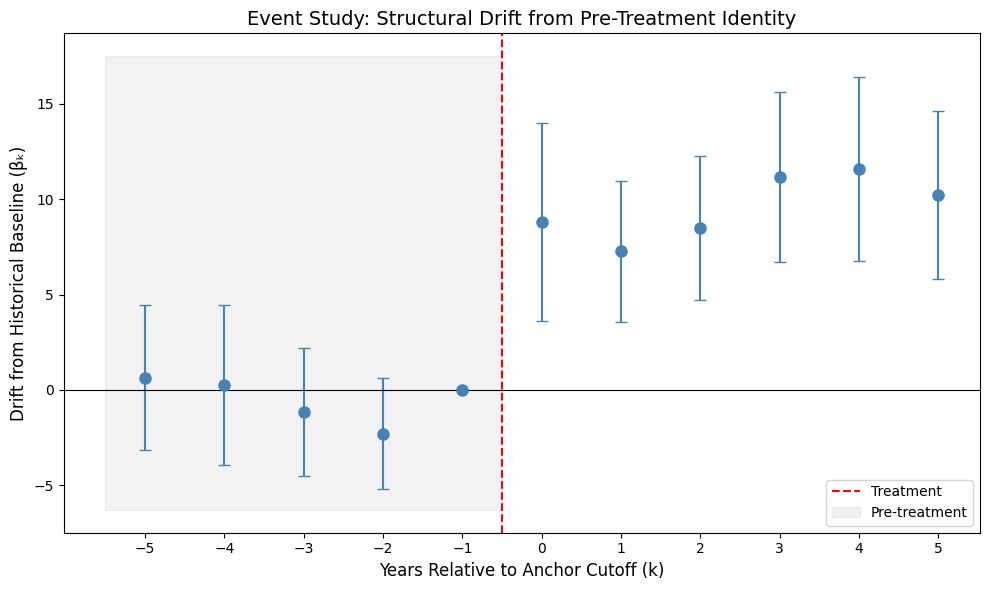


INTERPRETATION GUIDE

STATIC MODEL (β):
  • β > 0: Treated papers drifted FURTHER from their historical identity
          than control papers did — new publishers caused structural change.
  • β ≈ 0: No differential drift — new publishers maintained the old identity.

EVENT STUDY (βₖ):
  • Pre-treatment (k < -1): Should be ≈ 0 if parallel trends holds.
    Significant pre-trends suggest selection bias (papers were already drifting).
  • k = 0 onward: Shows when drift begins and whether it persists or fades.

  Pattern A: Immediate spike at k=0, stays elevated → Abrupt, lasting change.
  Pattern B: Gradual increase over k=0,1,2... → Slow strategic pivot.
  Pattern C: Spike then return to zero → Temporary disruption, regression to mean.



In [37]:
# actual regression

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load the structural drift panel
panel = pd.read_csv('panel_structural_drift.csv')

# =============================================================================
# Model 1: Static DiD
# Y_it = α_i + δ_t + β(Post_it) + ε_it
# Tests: Did treated papers drift further from baseline than controls?
# =============================================================================
reg_data = panel[['Newspaper_ID', 'Year', 'Post_it', 'Y_it', 'is_treated']].dropna()

static_model = smf.ols(
    'Y_it ~ Post_it + C(Newspaper_ID) + C(Year)',
    data=reg_data
).fit(cov_type='cluster', cov_kwds={'groups': reg_data['Newspaper_ID']})

print("=" * 70)
print("MODEL 1: STATIC DiD — Average Treatment Effect on Structural Drift")
print("=" * 70)
print(f"\nβ (Post_it):     {static_model.params['Post_it']:.4f}")
print(f"Std Error:       {static_model.bse['Post_it']:.4f}")
print(f"95% CI:          [{static_model.conf_int().loc['Post_it', 0]:.4f}, {static_model.conf_int().loc['Post_it', 1]:.4f}]")
print(f"P-value:         {static_model.pvalues['Post_it']:.4f}")
print(f"R-squared:       {static_model.rsquared:.4f}")
print(f"Observations:    {static_model.nobs:.0f}")

# =============================================================================
# Model 2: Event Study (Dynamic Effects)
# Y_it = α_i + δ_t + Σ β_k D^k_it + ε_it
# Shows timing of drift: immediate vs gradual?
# =============================================================================
K_MIN, K_MAX = -5, 5

# Calculate time relative to anchor cutoff
panel['Time_to_Treat'] = panel['Year'] - panel['Anchor_Cutoff_Year']

def bin_time(k):
    if pd.isna(k): return None
    if k < K_MIN: return f'k_{K_MIN}'
    if k > K_MAX: return f'k_{K_MAX}'
    return f'k_{int(k)}'

panel['event_time'] = panel['Time_to_Treat'].apply(bin_time)
panel['event_time'] = pd.Categorical(
    panel['event_time'],
    categories=[f'k_{k}' for k in range(K_MIN, K_MAX + 1)]
)

reg_data_es = panel[['Newspaper_ID', 'Year', 'event_time', 'Y_it']].dropna()

event_model = smf.ols(
    'Y_it ~ C(event_time, Treatment("k_-1")) + C(Newspaper_ID) + C(Year)',
    data=reg_data_es
).fit(cov_type='cluster', cov_kwds={'groups': reg_data_es['Newspaper_ID']})

# Extract coefficients for plotting
coefs = []
for k in range(K_MIN, K_MAX + 1):
    if k == -1:
        coefs.append({'k': k, 'beta': 0, 'ci_low': 0, 'ci_high': 0, 'pval': np.nan})
    else:
        param = f'C(event_time, Treatment("k_-1"))[T.k_{k}]'
        if param in event_model.params:
            coefs.append({
                'k': k,
                'beta': event_model.params[param],
                'ci_low': event_model.conf_int().loc[param, 0],
                'ci_high': event_model.conf_int().loc[param, 1],
                'pval': event_model.pvalues[param]
            })

coef_df = pd.DataFrame(coefs)

print("\n" + "=" * 70)
print("MODEL 2: EVENT STUDY — Dynamic Path of Structural Drift")
print("=" * 70)
print(coef_df.to_string(index=False, float_format='{:.4f}'.format))

# =============================================================================
# Plot: Event Study Coefficients
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(coef_df['k'], coef_df['beta'],
            yerr=[coef_df['beta'] - coef_df['ci_low'],
                  coef_df['ci_high'] - coef_df['beta']],
            fmt='o', capsize=4, color='steelblue', markersize=8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=1.5, label='Treatment')
ax.fill_betweenx(ax.get_ylim(), K_MIN - 0.5, -0.5, alpha=0.1, color='gray', label='Pre-treatment')

ax.set_xlabel('Years Relative to Anchor Cutoff (k)', fontsize=12)
ax.set_ylabel('Drift from Historical Baseline (βₖ)', fontsize=12)
ax.set_title('Event Study: Structural Drift from Pre-Treatment Identity', fontsize=14)
ax.set_xticks(range(K_MIN, K_MAX + 1))
ax.legend()

plt.tight_layout()
plt.savefig('structural_drift_event_study.png', dpi=150)
plt.show()

# =============================================================================
# Interpretation Guide
# =============================================================================
print("\n" + "=" * 70)
print("INTERPRETATION GUIDE")
print("=" * 70)
print("""
STATIC MODEL (β):
  • β > 0: Treated papers drifted FURTHER from their historical identity
          than control papers did — new publishers caused structural change.
  • β ≈ 0: No differential drift — new publishers maintained the old identity.

EVENT STUDY (βₖ):
  • Pre-treatment (k < -1): Should be ≈ 0 if parallel trends holds.
    Significant pre-trends suggest selection bias (papers were already drifting).
  • k = 0 onward: Shows when drift begins and whether it persists or fades.
    
  Pattern A: Immediate spike at k=0, stays elevated → Abrupt, lasting change.
  Pattern B: Gradual increase over k=0,1,2... → Slow strategic pivot.
  Pattern C: Spike then return to zero → Temporary disruption, regression to mean.
""")